In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from functions import *
import numpy as np
import os
import pandas as pd
import zlib
from functools import reduce
from itertools import combinations
import time
from matplotlib import pyplot as plt

In [62]:
document1 = "This is a sample text containing some random words"
document2 = "This is a sample text with different random words"
s1 = shingle(document1, k=9)
s2 = shingle(document2, k=9)
print(f'Jaccard similarity: {compareSets(s1, s2)}')

Jaccard similarity: 0.21818181818181817


In [63]:
min_hasher = MinHash(n=200)
sig1 = min_hasher.create_signature(s1)
sig2 = min_hasher.create_signature(s2)
print(f'Estimated Jaccard similarity: {compare_signatures(sig1, sig2)}')

Estimated Jaccard similarity: 0.245


Document 'MIX_OHIO_BROWN_CHEMLAWN.txt' is a mix of documents 'OHIO_MATTRESS.txt', 'BROWN_FORMAN.txt', and 'CHEMLAWN.txt'

Document 'MIX_CHEMLAWN_SHAMROCK.txt' is 'DIAMOND_SHAMROCK.txt' inserted into 'CHEMLAWN.txt'.

In [64]:
data = dict()
print('Documents in dataset:\n')
for i, filename in enumerate(os.listdir("dataset")):
    print(f'{i} {filename}')
    with open(os.path.join("dataset", filename), 'r') as f:
        data[filename[:-4]] = f.read()



Documents in dataset:

0 COMPUTER_TERMINAL_SYSTEMS.txt
1 OHIO_MATTRESS.txt
2 ARGENTINA_COULD_SUSPEND_DEBT PAYMENTS.txt
3 MIX_OHIO_BROWN_CHEMLAWN.txt
4 BRAZIL_ANTI_INFLATION_PLAN.txt
5 KEY_US_TAX_WRITERS_SEEK_ESTATE_TAX_CURBS.txt
6 TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND.txt
7 DEBT_DOWGRADED_BY_MOODYS.txt
8 CHEMLAWN.txt
9 US_BANK_DISCOUNT_BORROWINGS_310_MLN_DLRS.txt
10 QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY.txt
11 DIAMOND_SHAMROCK.txt
12 MIX_CHEMLAWN_SHAMROCK.txt
13 BROWN_FORMAN.txt
14 TALKING_POINT_BANKAMERICA.txt


In [65]:
#Shingling the dataset
list_of_data = [c for c in data]
shingled_data = dict()
THRES = 0.07
for c in data:
    shingled_data[c] = shingle(data[c], k=9)
    
#Creating signatures for the dataset
min_hasher = MinHash(n=200)
signed_data = dict()
for c in data:
    signed_data[c] = min_hasher.create_signature(shingled_data[c])

In [66]:
#Code for searching for similar pairs
def jaccard(c1, c2):
    return compareSets(shingled_data[c1], shingled_data[c2])

def jaccard_estimate(c1, c2, singnatures=signed_data):
    return compare_signatures(singnatures[c1], singnatures[c2])

def calculate_similarity_of_all_pairs(method, documents=list_of_data):
    result = pd.DataFrame(columns=documents)
    for row in documents:
        result[row] = [method(row, col) for col in documents]
    return result

In [67]:
def find_pairs_above_threshold(df, threshold, documents=list_of_data):
    checked = set()
    result = set()
    for col in df:
        checked.add(col)
        for i, sim in enumerate(df[col]):
            curr = documents[i]
            if curr in checked: continue
            if sim > threshold: result.add((col, curr))
    return result
            

PART 1, STUDY IN TRUE/FALSE POSITIVES

In [68]:
#Calculating the Jaccard similarity for every pair of documents
jaccard_sim_map = calculate_similarity_of_all_pairs(jaccard)

print(jaccard_sim_map)
gt_result = find_pairs_above_threshold(jaccard_sim_map, THRES)
print(gt_result)
    

    COMPUTER_TERMINAL_SYSTEMS  OHIO_MATTRESS  \
0                    1.000000       0.032844   
1                    0.032844       1.000000   
2                    0.027453       0.023948   
3                    0.041905       0.137717   
4                    0.031505       0.028986   
5                    0.034010       0.022397   
6                    0.053157       0.034633   
7                    0.025797       0.023445   
8                    0.039463       0.028425   
9                    0.037639       0.026209   
10                   0.043356       0.036420   
11                   0.025580       0.010811   
12                   0.046276       0.028271   
13                   0.037304       0.026866   
14                   0.046143       0.033172   

    ARGENTINA_COULD_SUSPEND_DEBT PAYMENTS  MIX_OHIO_BROWN_CHEMLAWN  \
0                                0.027453                 0.041905   
1                                0.023948                 0.137717   
2                    

In [69]:
#Estimating the Jaccard similarity for every pair of documents
jaccard_sim_estim_map = calculate_similarity_of_all_pairs(jaccard_estimate)

print(jaccard_sim_estim_map)
est_result = find_pairs_above_threshold(jaccard_sim_estim_map, THRES)
print(est_result)

print('Results of estimate')
acum = 0
for p in est_result:
    if p in gt_result or (p[1], p[0]) in gt_result: acum += 1
print(f'len of est_result: {len(est_result)}')
print(f'found {acum}/{len(gt_result)}')  # From these two lines we get infor about true/false positive rate

    COMPUTER_TERMINAL_SYSTEMS  OHIO_MATTRESS  \
0                       1.000          0.050   
1                       0.050          1.000   
2                       0.005          0.020   
3                       0.035          0.135   
4                       0.035          0.010   
5                       0.010          0.015   
6                       0.055          0.055   
7                       0.015          0.015   
8                       0.025          0.045   
9                       0.030          0.015   
10                      0.055          0.040   
11                      0.030          0.005   
12                      0.025          0.030   
13                      0.030          0.005   
14                      0.040          0.025   

    ARGENTINA_COULD_SUSPEND_DEBT PAYMENTS  MIX_OHIO_BROWN_CHEMLAWN  \
0                                   0.005                    0.035   
1                                   0.020                    0.135   
2                    

In [70]:
class LSH:
    def __init__(self, signatures, num_of_bands, threshold):
        self.sig = signatures
        self.num_of_bands = num_of_bands
        self.threshold = threshold
        self.buckets = dict()
        for k in self.sig: 
            assert len(self.sig[k]) % self.num_of_bands == 0
            self.width_of_band = int(len(self.sig[k]) / self.num_of_bands)
    
    def clear_buckets(self):
        for k in self.buckets:
            self.buckets[k].clear()
    
    def add_to_bucket(self, bucket, candidate):
        if not bucket in self.buckets: self.buckets[bucket] = set()
        self.buckets[bucket].add(candidate)
    
    def hash_band(self, band):
        reduced_band = reduce(lambda accum, x: f'{accum}{x}', band)
        return zlib.adler32(reduced_band.encode('utf8'))
    
    def get_candidates(self):
        result = set()
        for i in range(self.num_of_bands):
            self.clear_buckets()
            for doc in self.sig:
                #print(f'doc:{doc}, i:{i}, band:{self.sig[doc]}')
                hashed_band = self.hash_band(self.sig[doc][i*self.width_of_band:((i+1)*self.width_of_band)])
                self.add_to_bucket(bucket=hashed_band, candidate=doc)
            for b in self.buckets:
                result.update(set(combinations(self.buckets[b],2)))
        #print(f'Num of candidates: {len(result)}')
        return result
    
    def get_candidates_above_threshold(self, data_with_duplicates=False, method=jaccard):
        result = set()
        candidates = self.get_candidates()
        for c in candidates:
            first = c[0]
            second = c[1]
            if data_with_duplicates:
                first = first.split('-')[0]
                second = second.split('-')[0]
            if method(first, second) > self.threshold:
                result.add(c)
        return result
                
            
        

In [71]:
# Locally sesnsitive hashing
lsh = LSH(signatures=signed_data, num_of_bands=50, threshold=THRES)
lsh_result = lsh.get_candidates_above_threshold()


print('Results of LSH')                                                 # b = num_of_bands
for p in lsh_result:                                                    # t = threshold, r = rows within a band
    print(f'{jaccard_sim_map.loc[list_of_data.index(p[0]), p[1]]} {p}') # explain results with 1 - (1 - t^r)^b
print()
    
acum = 0
for p in lsh_result:
    if p in gt_result or (p[1], p[0]) in gt_result: acum += 1
print(f'len of est_result: {len(lsh_result)}')
print(f'found {acum}/{len(gt_result)}')

Results of LSH
0.5214231063504208 ('MIX_CHEMLAWN_SHAMROCK', 'MIX_OHIO_BROWN_CHEMLAWN')
0.5998240985048373 ('MIX_OHIO_BROWN_CHEMLAWN', 'CHEMLAWN')
0.8196885986941236 ('MIX_CHEMLAWN_SHAMROCK', 'CHEMLAWN')

len of est_result: 3
found 3/15


PART 2 STUDY IN SCALABILITY

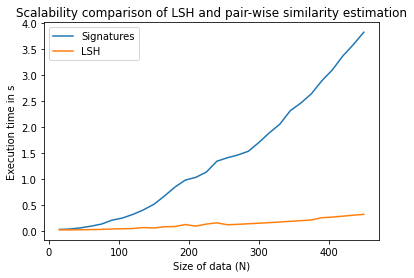

In [72]:
# We will get a sense of the speed of execution by applying the above described algorithms
# to a data set of incresing size
# we will construct the larger data sets by repeatedly copying the original back into the larger one
# The larger data set will contained duplicates

def dict_extend(d_to_extend, with_d, time):
    for k in with_d:
        d_to_extend[k + f'-{time}'] = with_d[k]

signature_time = []
lsh_time = []

NUM_OF_EXPERIMENTS = 30
larger_data = dict()
for i in range(NUM_OF_EXPERIMENTS):
    dict_extend(d_to_extend=larger_data, with_d=signed_data, time=i)
    doc_list = [k for k in larger_data]
    
    start = time.time()
    res = calculate_similarity_of_all_pairs(                                  \
                lambda a,b: jaccard_estimate(a, b, singnatures=larger_data),  \
                documents=doc_list                                            \
    )
    final = find_pairs_above_threshold(res, THRES, documents=doc_list)
    end = time.time()
    signature_time.append(end - start)
    
    
    start = time.time()
    lsh = LSH(signatures=larger_data, num_of_bands=50, threshold=THRES)
    lsh_result = lsh.get_candidates_above_threshold(data_with_duplicates=True, method=jaccard_estimate)
    end = time.time()
    lsh_time.append(end - start)


x = [i*15 for i in range(1,NUM_OF_EXPERIMENTS+1)]
plt.figure(1)
plt.plot(x, signature_time, label='Signatures')
plt.plot(x, lsh_time, label='LSH')
plt.ylabel('Execution time in s')
plt.xlabel('Size of data (N)')
plt.legend()
plt.title('Scalability comparison of LSH and pair-wise similarity estimation')
plt.show()

    

